*Credit: [Thomas Husken](thomas.husken@schibsted.com)

In [1]:
from dataclasses import dataclass
from typing import Dict, List, Union

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc.math as pmm
import copy
from scipy.stats import bernoulli, expon

print(f"Running on PyMC v{pm.__version__}")


Running on PyMC v5.4.0


In [2]:
RANDOM_SEED = 4000
rng = np.random.default_rng(RANDOM_SEED)

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

In [3]:
@dataclass
class BetaPrior:
    alpha: float
    beta: float

In [4]:
@dataclass
class BinomialData:
    trials: int
    successes: int

In [5]:
class ClickModel:
    def __init__(self, priors: BetaPrior):
        self.priors = priors

    def create_model(self, data: List[BinomialData]) -> pm.Model:
        trials = [d.trials for d in data]
        successes = [d.successes for d in data]
        with pm.Model() as model:
            p = pm.Beta("p", alpha=self.priors.alpha, beta=self.priors.beta, shape=4)
            y = pm.Binomial("y", n=trials, p=p, observed=successes)
            #
            uplift_male = pm.Deterministic("uplift_over_45", (p[1] - p[0])/ p[0])
            #
            uplift_female = pm.Deterministic("uplift_under_45", (p[3] - p[2])/ p[2])
        return model

In [6]:
n_success_challenger_over45 = 10218
n_success_baseline_over45 = 8393
n_trials_challenger_over45 = 122846 
n_trials_baseline_over45 = 122846 
n_success_challenger_under45 = 1566
n_success_baseline_under45 = 1400
n_trials_challenger_under45 = 24461 
n_trials_baseline_under45 = 24461 

In [7]:
weak_prior = ClickModel(BetaPrior(1, 1))
with weak_prior.create_model(data=[
      BinomialData(n_trials_baseline_over45, n_success_baseline_over45),
      BinomialData(n_trials_challenger_over45, n_success_challenger_over45),
      BinomialData(n_trials_baseline_under45, n_success_baseline_under45),
      BinomialData(n_trials_challenger_under45, n_success_challenger_under45),
    ]) as click_model: 
    trace_weak = pm.sample(draws=5000, return_inferencedata=True, cores=1, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 10 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [8]:
groups = ['Baseline Age > 45','Challenger Age > 45', 'Baseline Age <= 45', 'Challenger Age <= 45']

In [9]:
trace_weak.observed_data["y_dim_0"] = groups
trace_weak.posterior["p_dim_0"] = groups

array([[<AxesSubplot: title={'center': 'p\nBaseline Age > 45'}>,
        <AxesSubplot: title={'center': 'p\nChallenger Age > 45'}>],
       [<AxesSubplot: title={'center': 'p\nBaseline Age <= 45'}>,
        <AxesSubplot: title={'center': 'p\nChallenger Age <= 45'}>]],
      dtype=object)

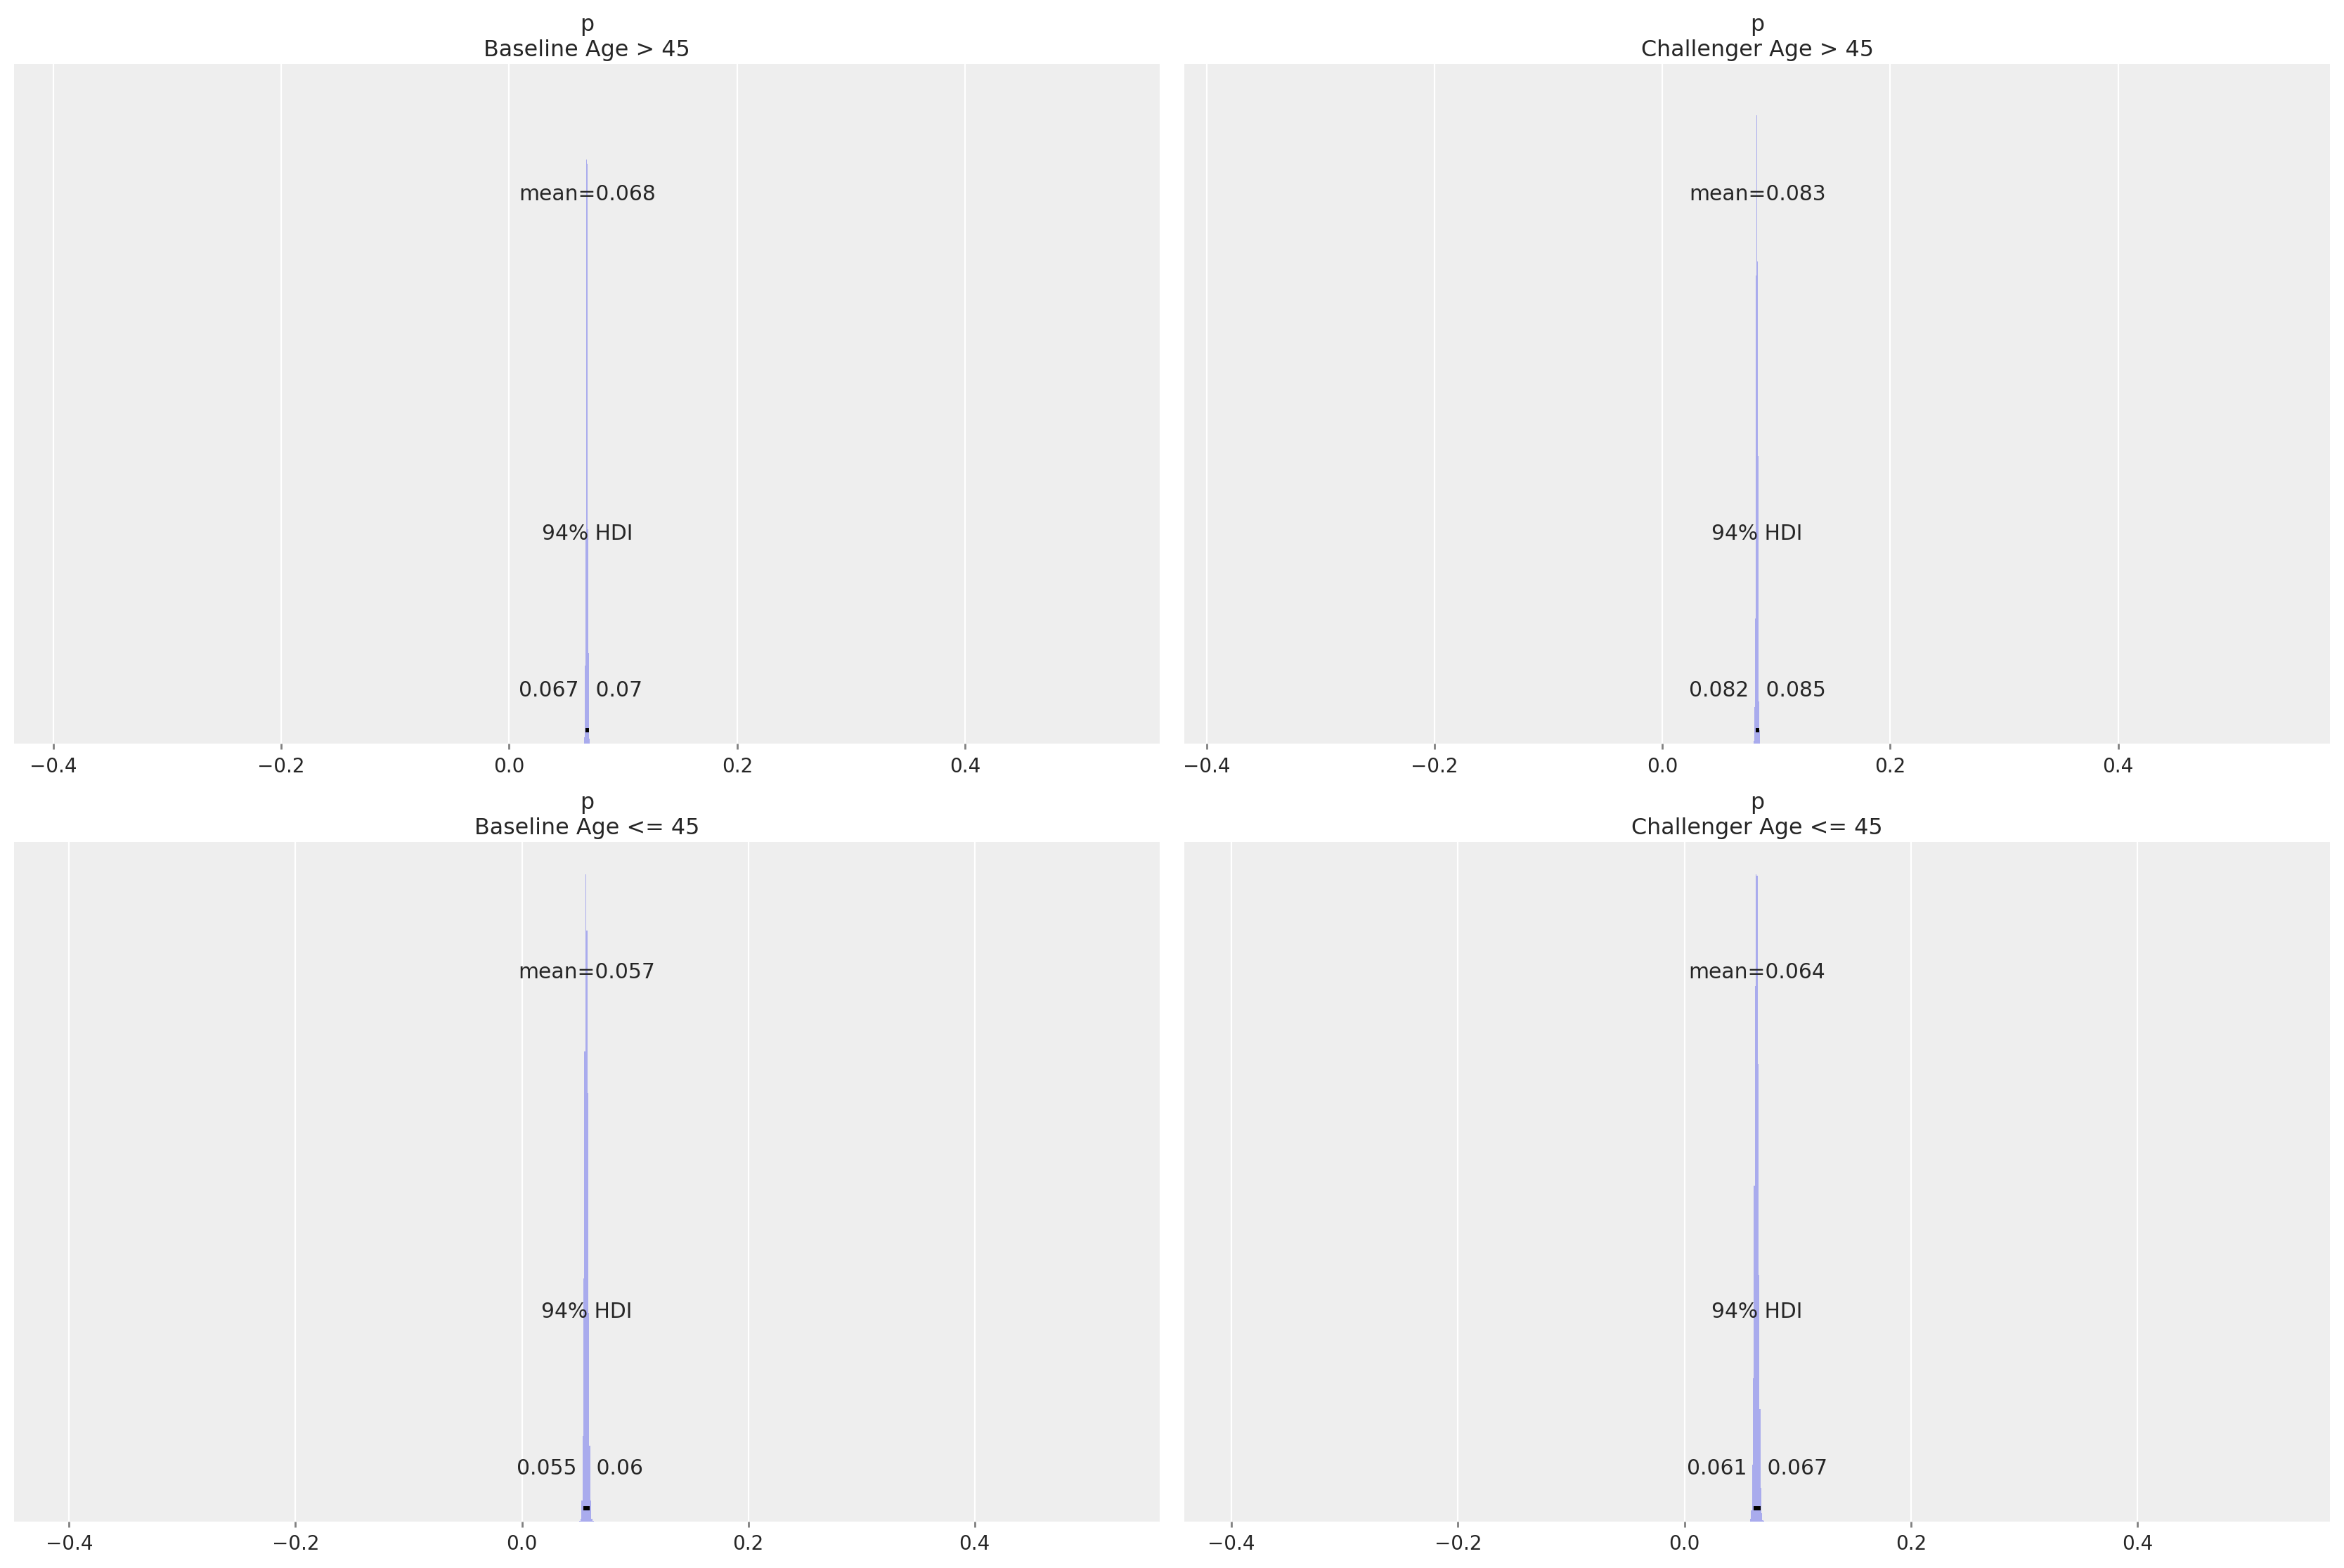

In [10]:
az.plot_posterior(trace_weak.posterior["p"], textsize=10, kind="hist", grid=(2,2))

"\nfig_123 = plt.gcf()\n#forsteFire = copy.deepcopy(fig_123)\nsisteTo = copy.deepcopy(fig_123)\n#for i in range(1,3):\n    #forsteFire.delaxes(forsteFire.axes[-1])\nfor i in range(0,4):\n    sisteTo.delaxes(sisteTo.axes[-3])\n#forsteFire.savefig('Figures_Bayesian_Analysis/age_94_credible.png',dpi=200,bbox_inches='tight')\nsisteTo.savefig('Figures_Bayesian_Analysis/age_uplift.png',dpi=200, bbox_inches='tight')\n"

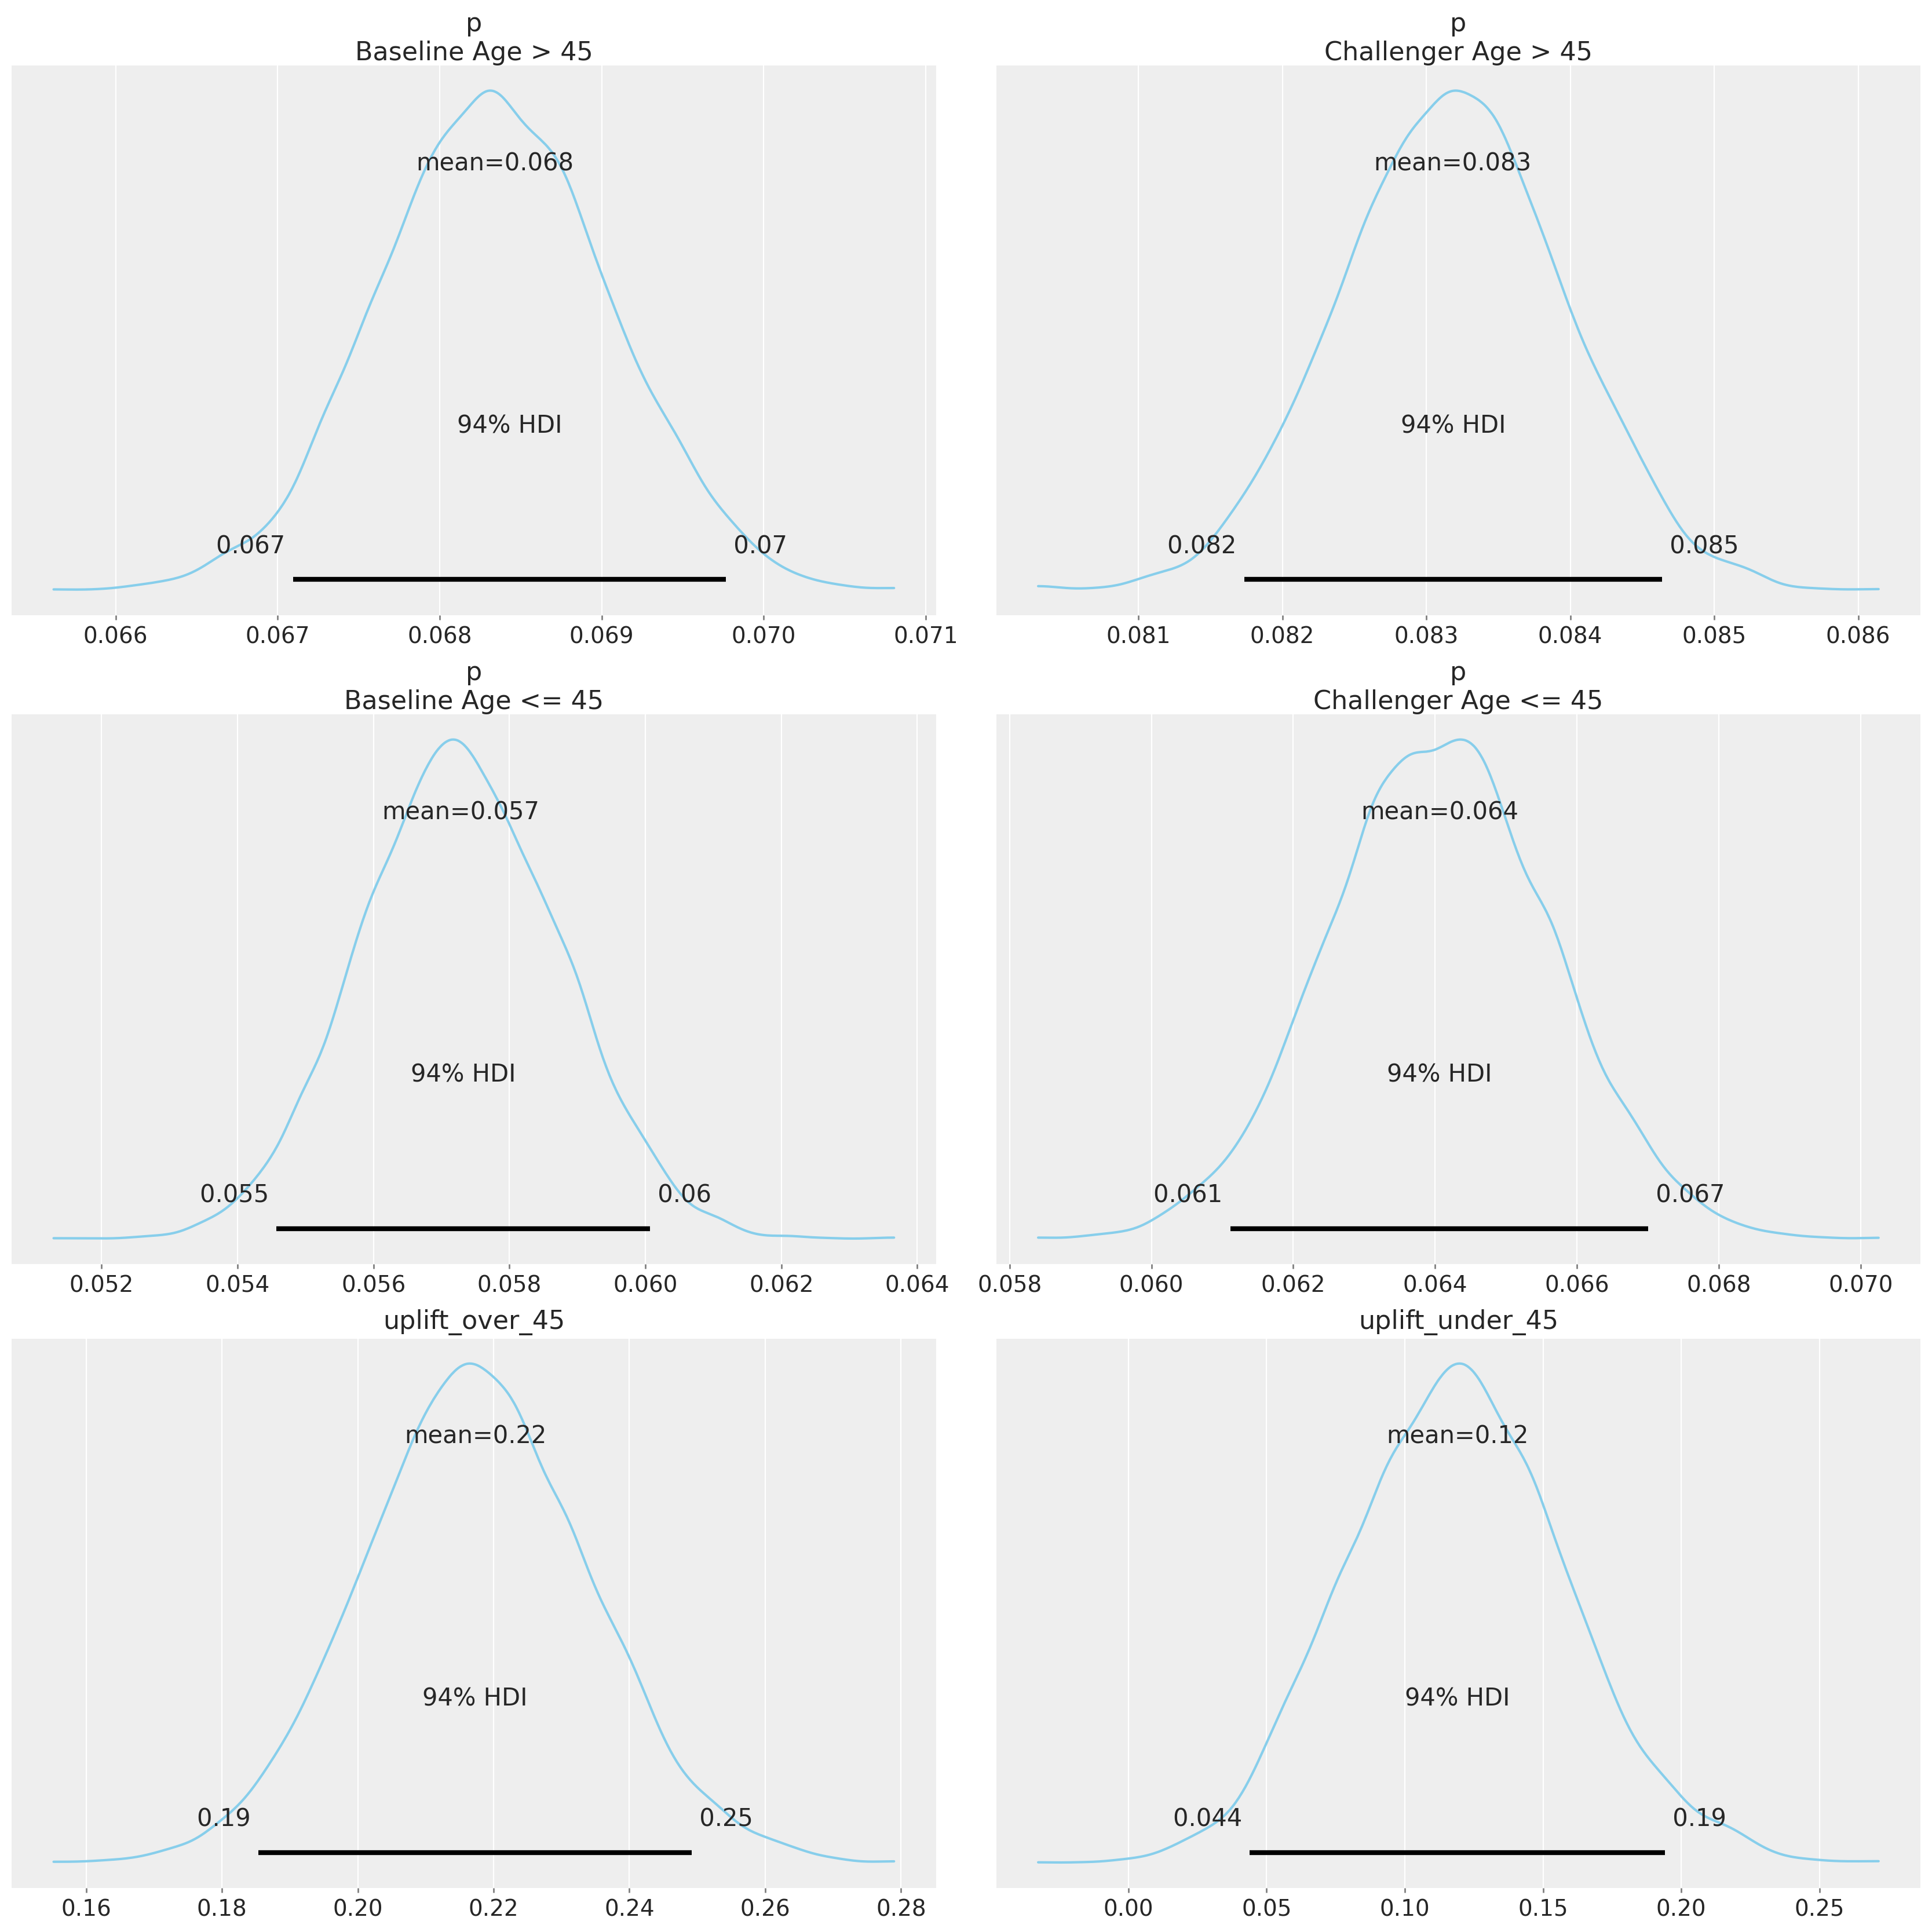

In [11]:
fig = pm.plot_posterior(trace_weak, color = '#87ceeb', grid=(3,2),round_to=2)#,var_names=['p'], grid=(2,2), round_to=4 #, grid=(3,2)
'''
fig_123 = plt.gcf()
#forsteFire = copy.deepcopy(fig_123)
sisteTo = copy.deepcopy(fig_123)
#for i in range(1,3):
    #forsteFire.delaxes(forsteFire.axes[-1])
for i in range(0,4):
    sisteTo.delaxes(sisteTo.axes[-3])
#forsteFire.savefig('Figures_Bayesian_Analysis/age_94_credible.png',dpi=200,bbox_inches='tight')
sisteTo.savefig('Figures_Bayesian_Analysis/age_uplift.png',dpi=200, bbox_inches='tight')
'''

In [12]:
over45_baseline = [[],[]]
over45_challenger = [[],[]]
under45_baseline = [[],[]]
under45_challenger = [[],[]]
for ind,chain in enumerate(trace_weak.posterior['p'].values):
    for j in chain:
        #print(j)
        over45_baseline[ind].append(j[0])
        over45_challenger[ind].append(j[1])
        under45_baseline[ind].append(j[2])
        under45_challenger[ind].append(j[3])
over45_baseline = np.array([np.array(x) for x in over45_baseline])
over45_challenger = np.array([np.array(x) for x in over45_challenger])
under45_baseline = np.array([np.array(x) for x in under45_baseline])
under45_challenger = np.array([np.array(x) for x in under45_challenger])

In [13]:
print(f'Probability that challenger is better than baseline for age over 45 = {(over45_challenger > over45_baseline).mean():.1%}.')

Probability that challenger is better than baseline for age over 45 = 100.0%.


In [14]:
print(f'Probability that challenger is better than baseline for age under 45 = {(under45_challenger > under45_baseline).mean():.1%}.')

Probability that challenger is better than baseline for age under 45 = 99.9%.


array([[<AxesSubplot: title={'center': 'p'}>,
        <AxesSubplot: title={'center': 'p'}>],
       [<AxesSubplot: title={'center': 'uplift_over_45'}>,
        <AxesSubplot: title={'center': 'uplift_over_45'}>],
       [<AxesSubplot: title={'center': 'uplift_under_45'}>,
        <AxesSubplot: title={'center': 'uplift_under_45'}>]], dtype=object)

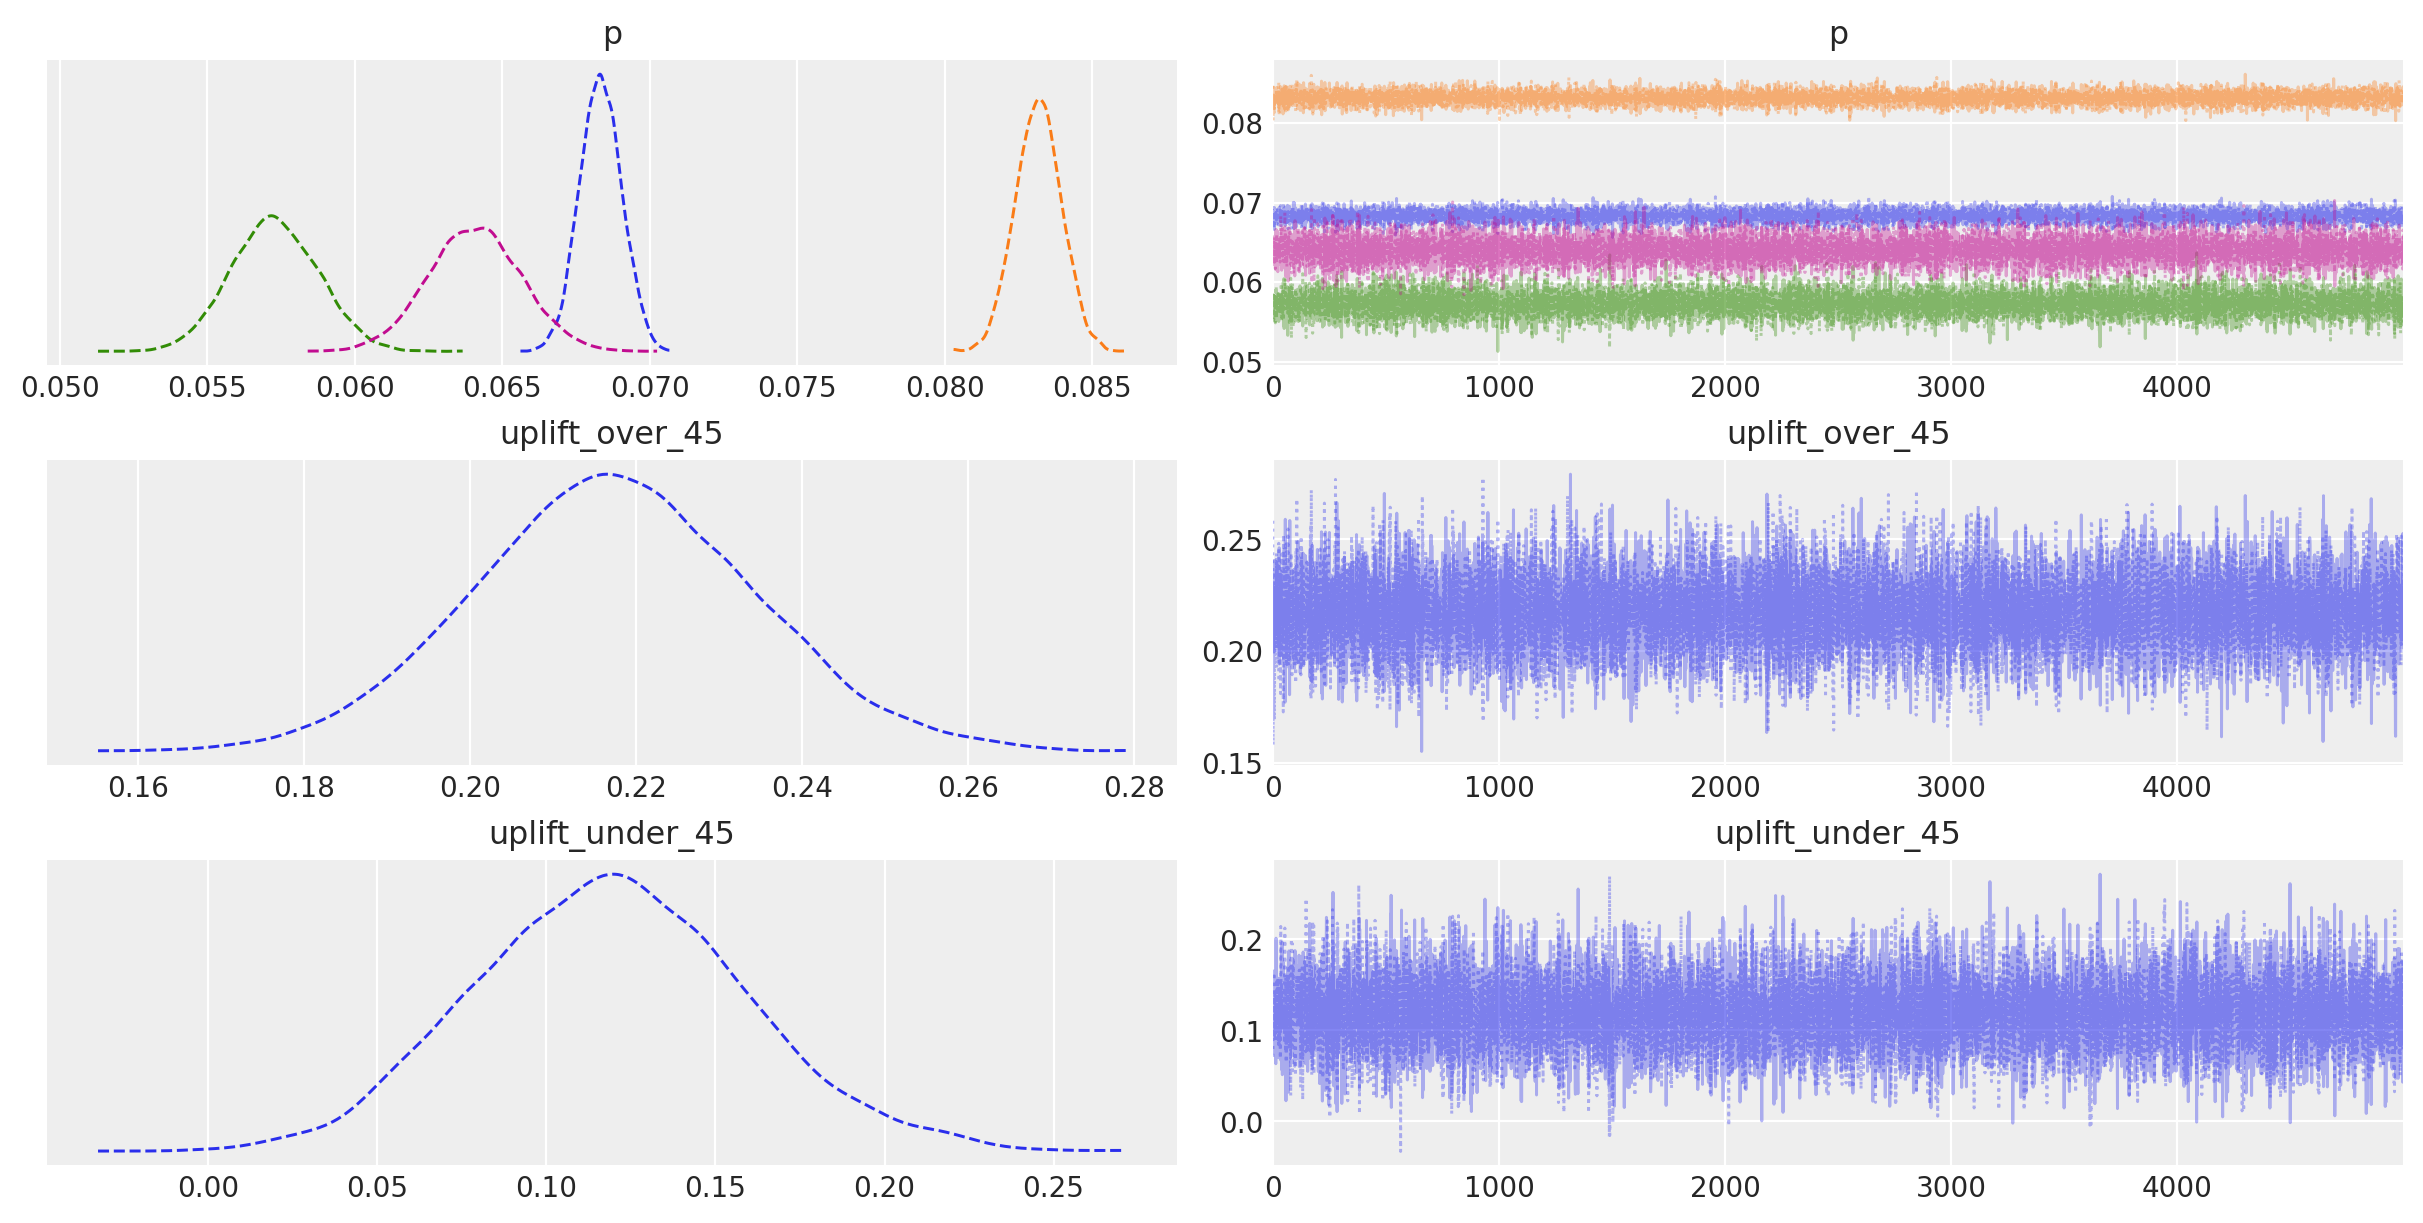

In [15]:
az.plot_trace(
    trace_weak,
    combined=True,
    compact=True,
    coords = {"p_dim_0":groups}
)

array([[<AxesSubplot: title={'center': 'p\nBaseline Age > 45'}>,
        <AxesSubplot: title={'center': 'p\nBaseline Age > 45'}>],
       [<AxesSubplot: title={'center': 'p\nChallenger Age > 45'}>,
        <AxesSubplot: title={'center': 'p\nChallenger Age > 45'}>],
       [<AxesSubplot: title={'center': 'p\nBaseline Age <= 45'}>,
        <AxesSubplot: title={'center': 'p\nBaseline Age <= 45'}>],
       [<AxesSubplot: title={'center': 'p\nChallenger Age <= 45'}>,
        <AxesSubplot: title={'center': 'p\nChallenger Age <= 45'}>],
       [<AxesSubplot: title={'center': 'uplift_over_45'}>,
        <AxesSubplot: title={'center': 'uplift_over_45'}>],
       [<AxesSubplot: title={'center': 'uplift_under_45'}>,
        <AxesSubplot: title={'center': 'uplift_under_45'}>]], dtype=object)

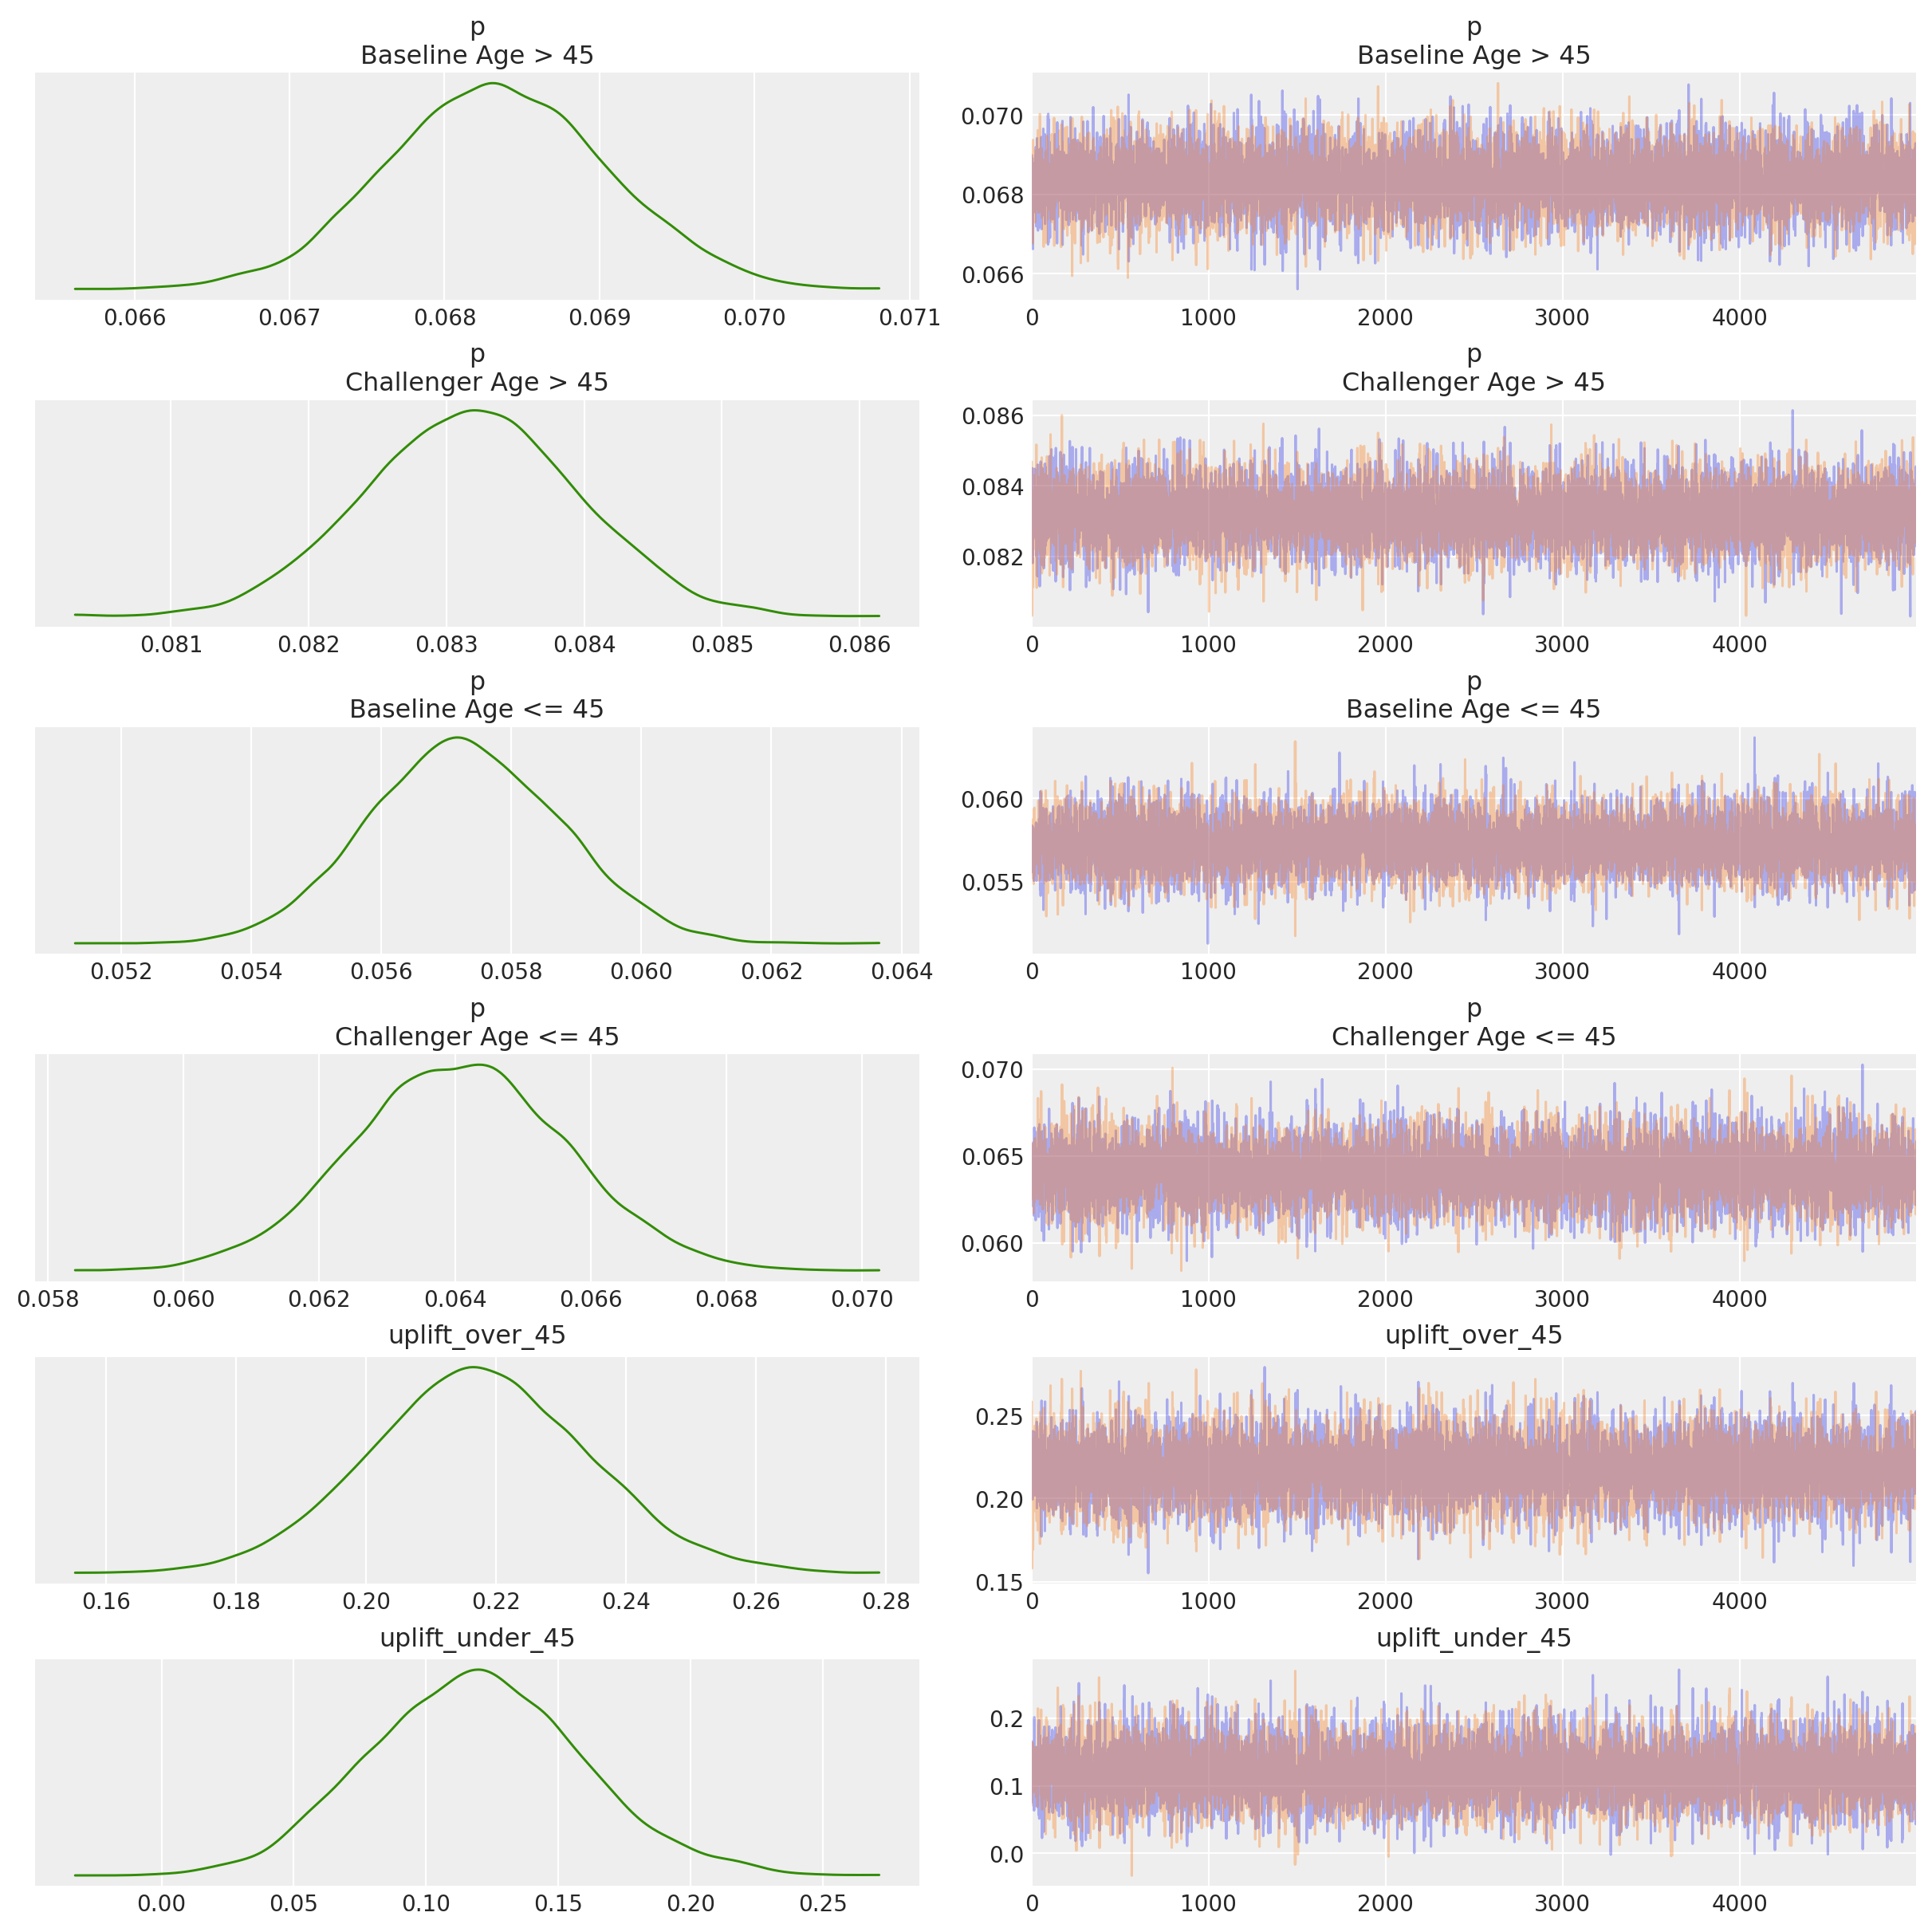

In [16]:
az.plot_trace(
    trace_weak,
    combined=True,
    compact=False,
    coords = {"p_dim_0":groups},
    backend_kwargs={"constrained_layout": True}
)

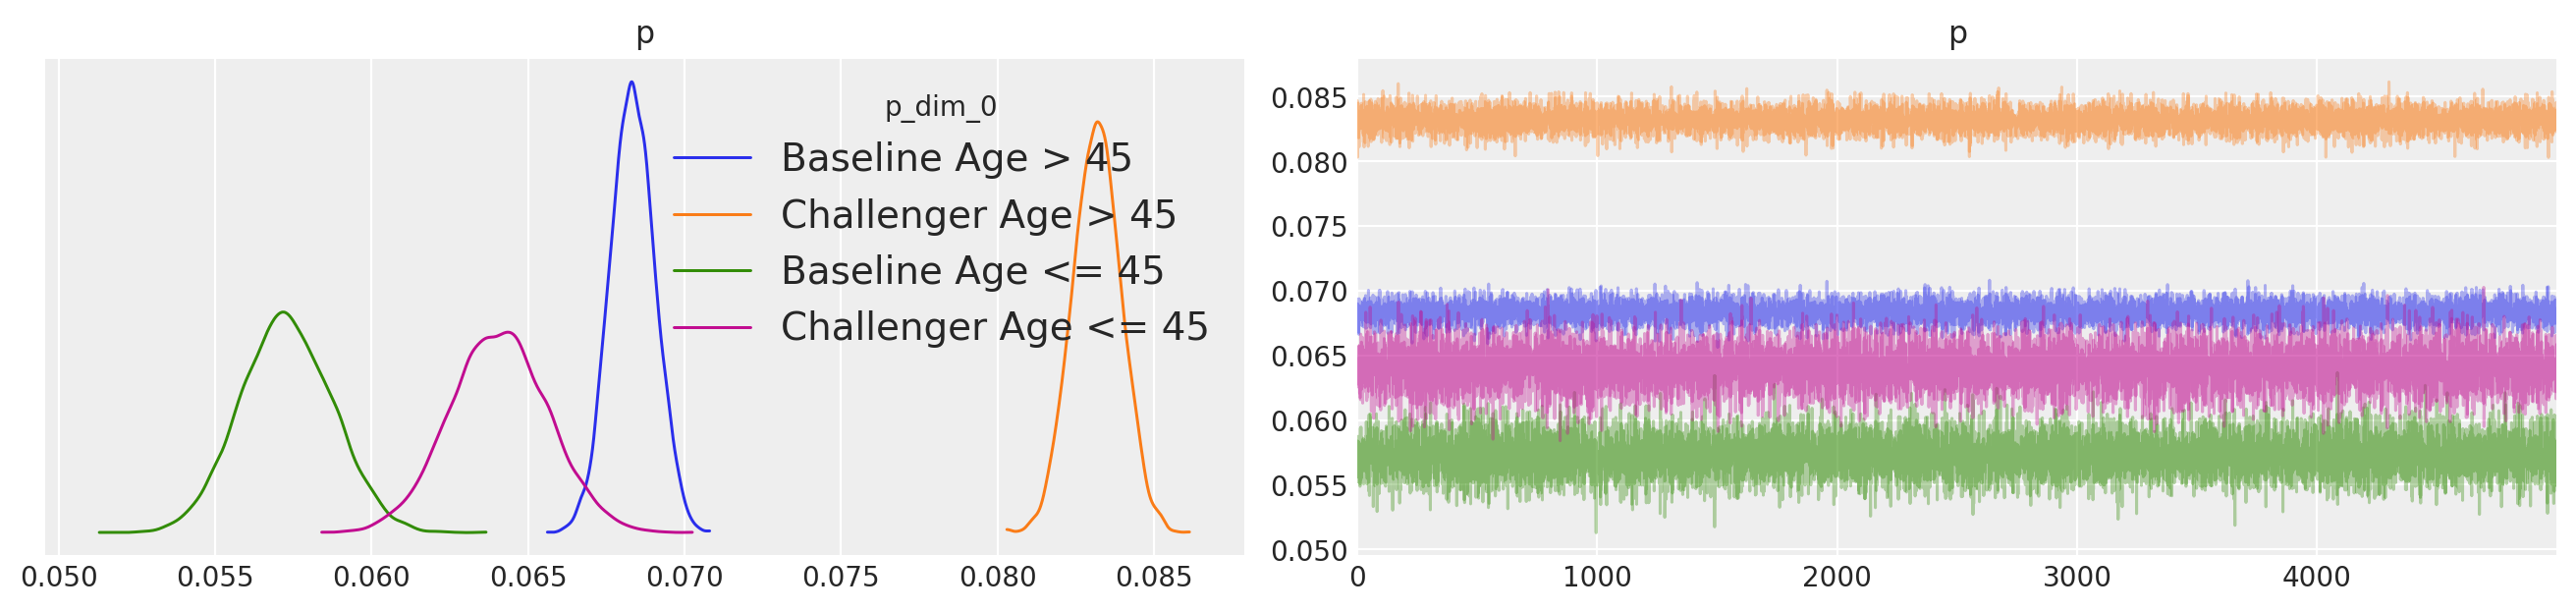

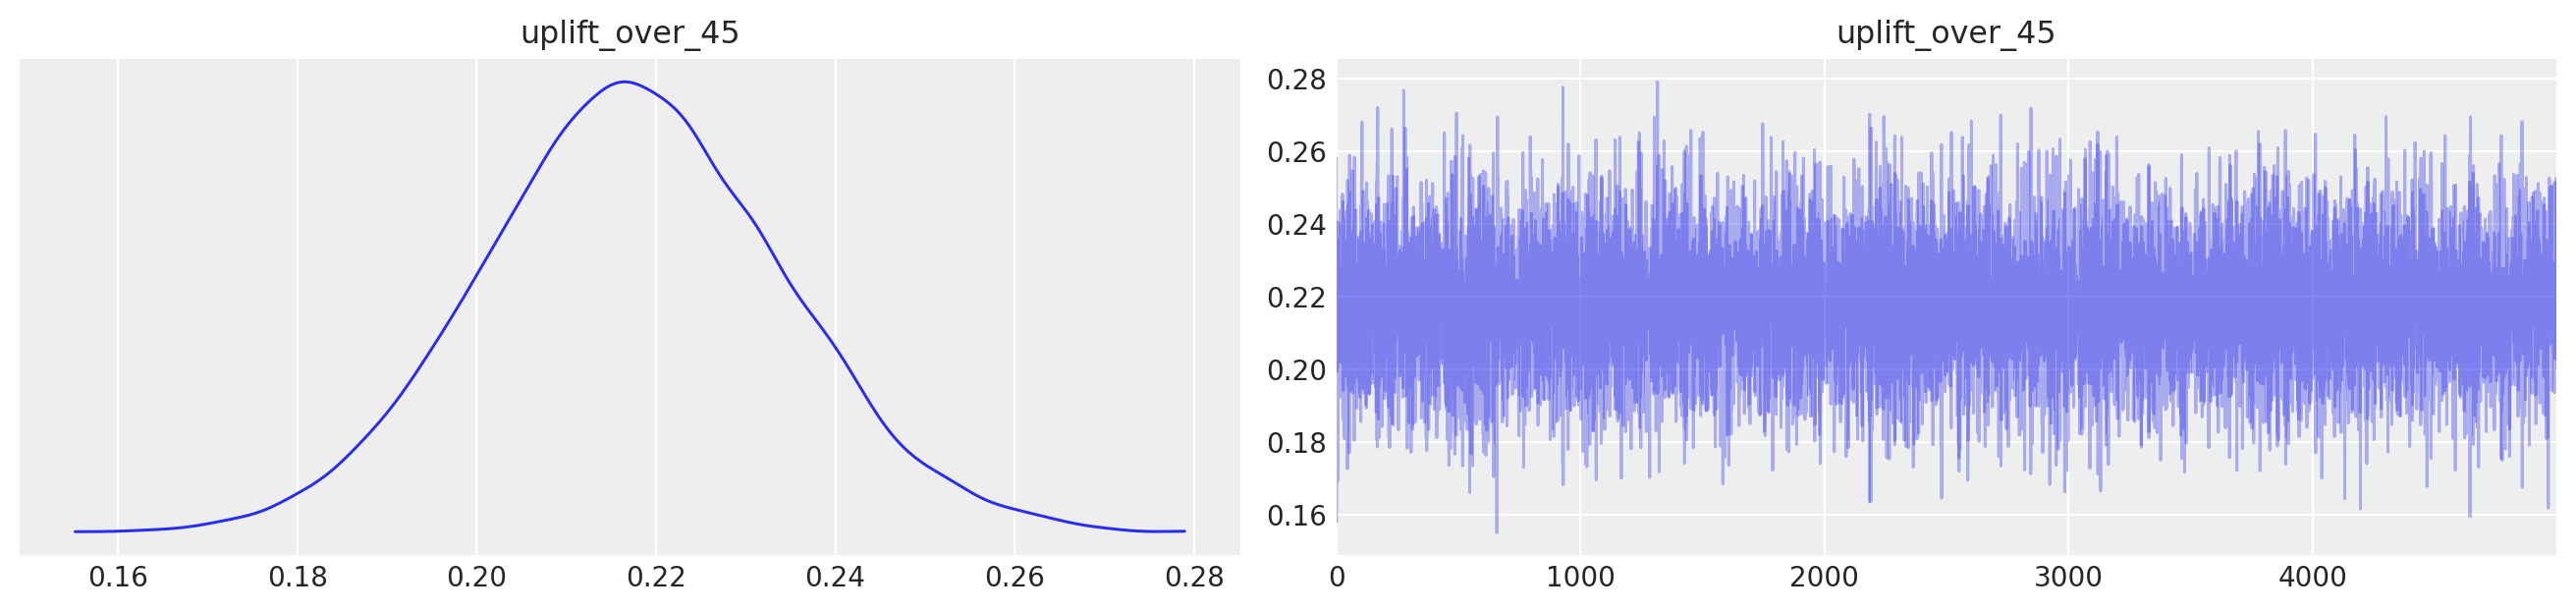

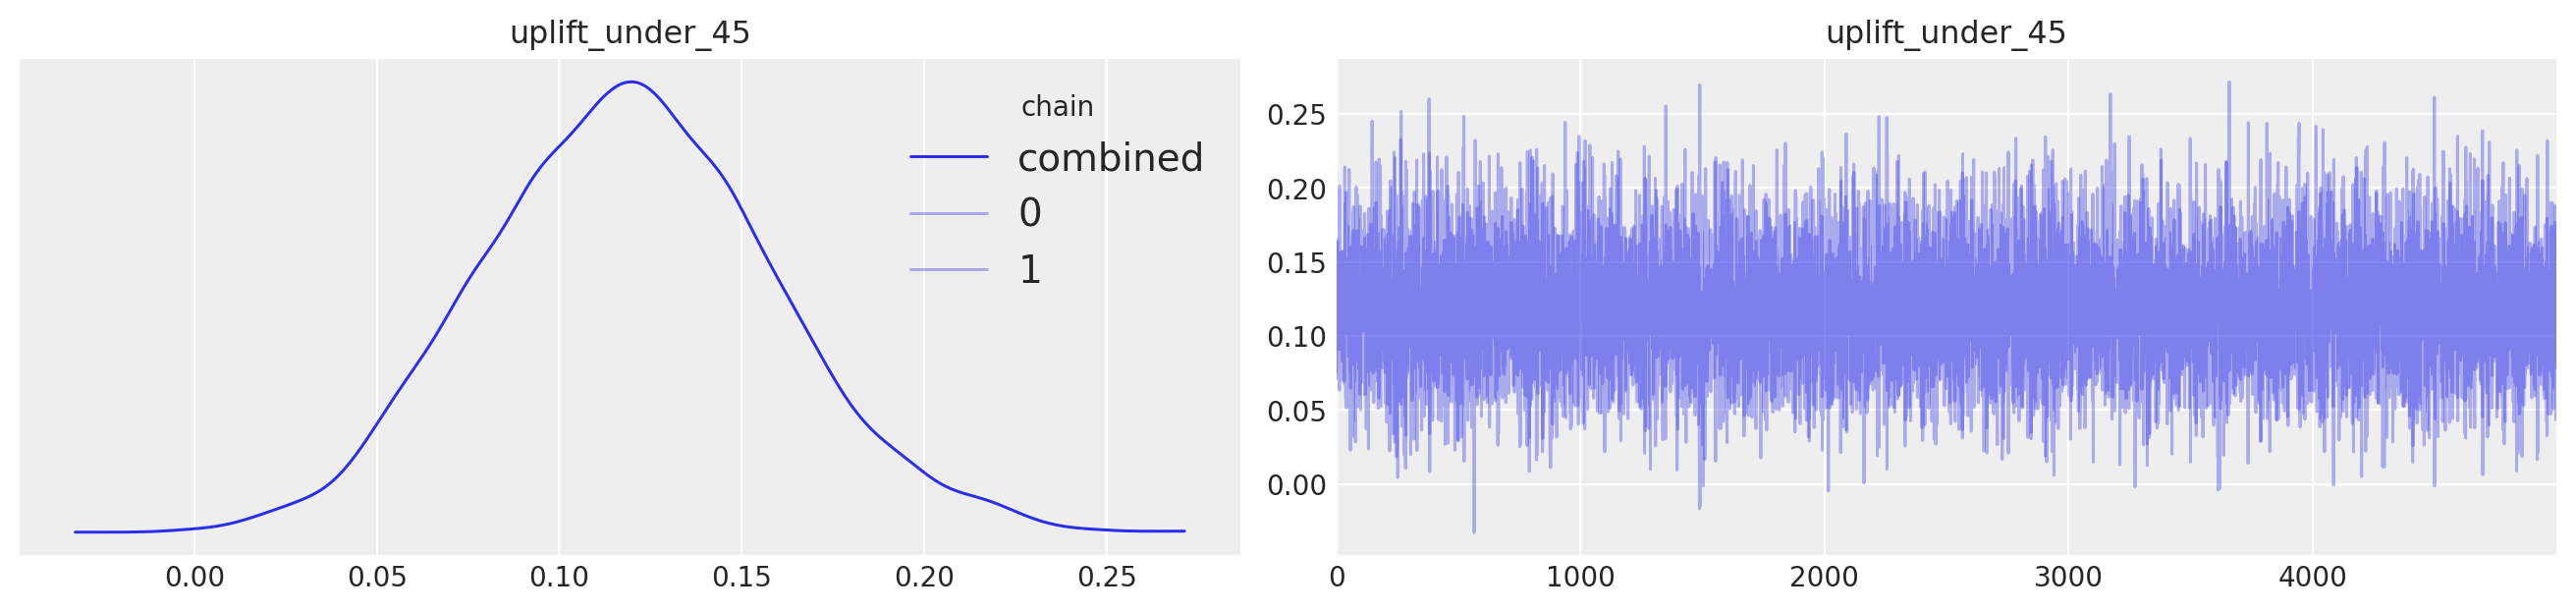

"\nfig1 = copy.deepcopy(_1)\nprint(fig1.axes)\nfig1.delaxes(fig1.axes[1])\nfig1.savefig('Figures_Bayesian_Analysis/age_distributions.png',dpi=200,bbox_inches='tight')\n"

In [17]:
size = (13, 3)
_1, ax1 = plt.subplots(1, 2, figsize=size)
_2, ax2 = plt.subplots(1, 2, figsize=size)
_3, ax3 = plt.subplots(1, 2, figsize=size)
ax = np.vstack((ax1, ax2, ax3))
az.plot_trace(
    trace_weak, 
    var_names=["p", "uplift_over_45", "uplift_under_45"], 
    compact=True,
    combined=True,
    legend=True,
    axes=ax,
    show=True,
    chain_prop={"ls": "-"}
)

'''
fig1 = copy.deepcopy(_1)
print(fig1.axes)
fig1.delaxes(fig1.axes[1])
fig1.savefig('Figures_Bayesian_Analysis/age_distributions.png',dpi=200,bbox_inches='tight')
'''

In [18]:
summary = az.summary(trace_weak, round_to=3)

In [19]:
text = ''
for i,r in summary.iterrows():
    mean = r['mean']
    sd = r['sd']
    p3 = r['hdi_3%']
    p97 = r['hdi_97%']
    temp = f'{mean} & {sd} & {p3} & {p97}\\\ \n'
    text +=temp
    #print(temp)
    #print(r['mean'])
print(text)

0.068 & 0.001 & 0.067 & 0.07\\ 
0.083 & 0.001 & 0.082 & 0.085\\ 
0.057 & 0.001 & 0.055 & 0.06\\ 
0.064 & 0.002 & 0.061 & 0.067\\ 
0.217 & 0.017 & 0.185 & 0.249\\ 
0.119 & 0.04 & 0.044 & 0.194\\ 

